# Skin Tone Comparison

- [Skin tone extraction](#extract)
- [Skin tone comparison](#compare)

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import face_recognition
from PIL import Image, ImageDraw

In [3]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os
from PIL import Image

workers = 0 if os.name == 'nt' else 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [4]:
from sklearn.cluster import KMeans
import math

## Utility functions

In [5]:
def extract_skin_colours(img, face_landmarks):
    '''
    Given an image, location of the face and face landmarks,
    extract out the left and right eyes, top and bottom lips.
    
    :param img: an image read using Python Imaging Library (PIL)
    :type img: PIL.Image.Image
    
    :param face_location: coordinates indicating where the face is in `img`
    :type face_location: list of length 4, representing top, right, bottom, left
    
    :param face_landmarks: a dictionary of list of points that describe the points of each 
        face landmark, for e.g.
        ```
        {'left_eye': [(520, 132), (533, 123), (549, 122), (564, 124), (579, 130)],
         'right_eye': [(604, 132), (620, 128), (635, 128), (650, 132), (660, 142)]}
        ```
    :type face_landmarks: dictionary of iterable of iterable of 2 int
    
    :return skin_colours: rgb values of the pixels identified as the skin
    :rtype skin_colours: numpy.ndarray
    
    :return skin_img: an image showing only the skin, the rest of the non-skin areas of the 
        image are in white.
    :rtype skin_img: PIL.Image.Image
    '''
    
    # convert to numpy (for convenience)
    imArray = np.asarray(img)
    
    ##################### retain face area only ####################
    # create mask full of ones, essentially an image with zero-values
    maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]), 0)
    
    d = ImageDraw.Draw(maskIm)
    
    # extract only the face
    d.polygon(face_landmarks['chin'], outline=1, fill=1)

    # obtain the pixel values from the PIL image
    mask = np.array(maskIm)

    # assemble new image (uint8: 0-255)
    newImArray = np.empty(imArray.shape,dtype='uint8')

    # colors (three first columns, RGB)
    newImArray[:,:,:3] = imArray[:,:,:3]

    # transparency (4th column)
    newImArray[:,:,3] = mask*255
    
    ##################### remove face landmarks ####################
    # create mask full of ones    
    d = ImageDraw.Draw(maskIm)
    
    # for each facial landmark ...
    for face_landmark in face_landmarks:
        # do not remove the chin area
        if face_landmark == 'chin':
            continue
        
        # create a polygon full of zeros wihtin the mask of ones
        polygon = face_landmarks[face_landmark]
        d.polygon(polygon, outline=0, fill=0)

    # obtain the pixel values from the PIL image
    mask = np.array(maskIm)

    # assemble new image (uint8: 0-255)
    finalImArray = np.empty(newImArray.shape,dtype='uint8')

    # colors (three first columns, RGB)
    finalImArray[:,:,:3] = newImArray[:,:,:3]

    # transparency (4th column)
    finalImArray[:,:,3] = mask*255

    # back to Image from numpy
    skin_img = Image.fromarray(finalImArray, "RGBA")
    
    ################### extract skin colours ###################
    skin_colours = []
    pixel_values = np.asarray(skin_img)

    height, width, channels = pixel_values.shape

    for i in range(height):
        for j in range(width):
            colour = pixel_values[i][j]

            if colour[3] != 0:
                skin_colours.append(colour[:3])

    skin_colours = np.asarray(skin_colours)
    
    return skin_colours, skin_img

def get_skin_tone(skin_rgb, method='median', num_tones=2):
    '''
    Extract the skin tone (RGB values) from a list of RGB values of the skin.
    
    :param skin_rgb: an array of RGB values of skin
    :type skin_rgb: numpy.ndarray
    
    :param method: the method to extract the skin tones
    :type method: str
    
    :param num_tones: number of top skin tones to extract, only applicable if 
        `method = 'knn'`
    :type num_tones: int
    
    :return skin_tone: the RGB value(s) of the skin tone of the input skin rgb
    :rtype skin_tone: numpy.ndarray
    
    Example:
    ```
    >>> skin_rgb = skin_rgb = np.array([[148, 128, 121],
                                        [144, 124, 117],
                                        [142, 121, 116],
                                        [106,  75,  73],
                                        [106,  75,  73],
                                        [111,  81,  83]])
    >>> get_skin_tone(skin_rgb, method='knn', num_tones=2)
    
    [[107,  77,  76],
     [144, 124, 118]]
     
    >>> skin_rgb = skin_rgb = np.array([[148, 128, 121],
                                        [144, 124, 117],
                                        [142, 121, 116],
                                        [106,  75,  73],
                                        [106,  75,  73],
                                        [111,  81,  83]])
    >>> get_skin_tone(skin_rgb, method='median', num_tones=2)
    
    [[126, 101,  99]]
    ```
    '''
    
    # mean of the rgb values
    if method == 'mean':
        skin_tone = np.asarray(np.mean(skin_rgb, axis=0), dtype=int)
        
        # make it an array of array for consistency of return type
        skin_tones = np.array([skin_tone])
        return skin_tones
    
    # median of the rgb values
    elif method == 'median':
        skin_tone = np.asarray(np.median(skin_rgb, axis=0), dtype=int)
        # make it an array of array for consistency of return type
        skin_tones = np.array([skin_tone])
        return skin_tones
    
    # K nearest neighbours of the rgb values
    elif method == 'knn':
        skin_clusters = KMeans(n_clusters=num_tones, random_state=42).fit(skin_rgb)
        skin_tones = np.array(skin_clusters.cluster_centers_, dtype=int)
        return skin_tones
    else:
        raise ValueError('Please specify a valid method to extract skin tone.')

def get_skin_tone_similarity(rgb1, rgb2, method="mean"):
    '''
    Obtain the percentage similarity between 2 skin tones.
    A score between 0 to 1 is returned, 0 meaning totally dissimilar,
    1 meaning exactly the same.
    
    A research paper about the best distance metric of two skin rgb values can be found in: 
    http://dx.doi.org/10.5121/csit.2013.3210.
    
    :param rgb1: rgb value(s) of skin tone 1
    :type rgb1: numpy.ndarray
    
    :param rgb2: rgb value(s) of skin tone 2
    :type rgb2: numpy.ndarray
    
    :return skin_tone_similarity: percentage similarity between 2 skin tones
    :rtype skin_tone_similarity: float
    '''
    
    assert rgb1.shape == rgb2.shape
    num_skin_tones = len(rgb1)
    
    skin_tone_similarities = 0
    
    for i in range(num_skin_tones):
        abs_diff = np.abs(rgb1[i] - rgb2[i])
        skin_tone_similarities += 1 - np.mean(abs_diff / 255)
    
    skin_tone_similarity = skin_tone_similarities / num_skin_tones
    
    return skin_tone_similarity

def get_face_landmarks(image_path, method="dlib"):
    '''
    Return the facial landmarks if one and only one face is found in `image_path`.
    
    :param image_path: filepath to an image
    :type image_path: str
    
    :param method: method used to detect facial landmarks
    :type method: str
    
    :return face_landmarks: a dictionary of face landmark and the coordinates
    :rtype face_landmarks: dict
    '''
    
    if method == "dlib":
        # load the image file
        image = face_recognition.load_image_file(image_path)
        
        # detect the bounding box containing the face
        face_locations = face_recognition.face_locations(image)
        
        # if more than 1 face is detected, `None` value is returned
        if len(face_locations) != 1:
            return None, None
        
        # obtain coordinates of the facial features, `chin`, `eyes` etc
        face_landmarks_list = face_recognition.face_landmarks(image, face_locations, model='large')
        
        # if no facial features are detected or more than 1 set of facial features are detected, 
        # `None` values are returned
        if len(face_landmarks_list) != 1:
            return None, None
    
        face_landmarks = face_landmarks_list[0]
        
        return face_landmarks, image
    
    elif method == "facenet":
        image = Image.open(image_path).convert("RGB")

        mtcnn = MTCNN(
            image_size=160, margin=20, min_face_size=20, keep_all=True,
            device=device
        )

        tensor_image = mtcnn(image)
        
        # if more than 1 face is detected or no face is detected, `None` values are returned
        if tensor_image is None or tensor_image.shape[0] != 1:
            return None, None
        
        # convert the tensor image to RGB valued image in numpy 
        image = np.array(((tensor_image[0]+1)/2 * 255).permute(1, 2, 0), dtype='uint8')
        
        # obtain coordinates of the facial features, `chin`, `eyes` etc
        face_landmarks_list = face_recognition.face_landmarks(image, model='large')
        
        # if no facial features are detected or more than 1 set of facial features are detected, 
        # `None` values are returned
        if len(face_landmarks_list) != 1:
            return None, None
        
        face_landmarks = face_landmarks_list[0]
        
        return face_landmarks, image
        
def get_skin_tone_similarity_face(image_path_1, image_path_2):
    '''
    Obtain the percentage similarity between 2 skin tones from 2 images.
    
    If exactly 1 face is found in each image, a score between 0 to 1 is returned, 
    0 meaning totally dissimilar, 1 meaning exactly the same;
    else, return None
    
    :param image_path_1: filepath to the first image
    :type image_path_1: str
    
    :param image_path_2: filepath to the second image
    :type image_path_2: str
    
    :return skin_tone_similarity: percentage similarity between 2 skin tones
    :rtype skin_tone_similarity: float
    
    :return skin_1: an image showing only the skin of `image_path_1`, 
        the rest of the non-skin areas of the image are in white.
    :rtype skin_1: PIL.Image.Image
    
    :return skin_2: an image showing only the skin of `image_path_2`, 
        the rest of the non-skin areas of the image are in white.
    :rtype skin_2: PIL.Image.Image
    
    :return skin_tone_1: rgb value of skin tone of `image_path_1`
    :rtype skin_tone_1: numpy.ndarray
    
    :return skin_tone_2: rgb value of skin tone of `image_path_2`
    :rtype skin_tone_2: numpy.ndarray
    '''
    
    skin_tones = []
    skin_imgs = []
    
    for image_path in [image_path_1, image_path_2]:
        print(image_path)
        
        # try obtaining facial landmarks using facenet
        face_landmarks, image = get_face_landmarks(image_path, method="facenet")
        
        if face_landmarks is not None:
            image = Image.fromarray(image).convert("RGBA") 
        
        #  if facenet fails, try obtaining facial landmarks using dlib
        else:
            face_landmarks, image = get_face_landmarks(image_path, method="dlib")
            
            # if both method fails, return none
            if face_landmarks is None:
                return None, None, None, None, None
            else:
                image = Image.open(image_path).convert("RGBA")
        
        # extract the RGB pixel values of the skin colour on the face
        skin_colours, skin_img = extract_skin_colours(image, face_landmarks)
        
        # compute a skin tone value from the collection of skin RGB colours
        skin_tone = get_skin_tone(skin_colours, method='knn')
        
        skin_imgs.append(skin_img)
        skin_tones.append(skin_tone)
    
    # compute a similarity score between 2 collection of skin tones
    skin_tone_similarity = get_skin_tone_similarity(skin_tones[0], skin_tones[1])
    
    skin_1 = skin_imgs[0]
    skin_2 = skin_imgs[1]
    skin_tone_1 = skin_tones[0]
    skin_tone_2 = skin_tones[1]
    
    return skin_tone_similarity, skin_1, skin_2, skin_tone_1, skin_tone_2

def rgb_to_hex(rgb):
    '''
    Converts RGB values to hex values.
    
    :param rgb: rgb value
    :type rgb: iterable of length 3
    
    :return hex_code: a hex code for `rgb`
    :rtype hex_code: str
    
    Example:
    ```
    >>> rgb_to_hex([255,255,255])
    '#ffffff'
    ```
    '''
    int_to_hex = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4',
                  5:'5', 6:'6', 7:'7', 8:'8', 9:'9',
                  10:'A', 11:'B', 12:'C', 13:'D',
                  14:'E', 15:'F'}
    hex_code = '#'
    
    for channel in rgb:
        hex_code += hex(channel)[-2:]
    
    return hex_code

In [5]:
IMAGE_PATH_1 = "../images/politician_baey_yam_keng/00001.jpg"
IMAGE_PATH_2 = "../images/politician_baey_yam_keng/00012.jpg"

In [6]:
image_path = IMAGE_PATH_1

# try obtaining facial landmarks using facenet
face_landmarks, image = get_face_landmarks(image_path, method="facenet")

if face_landmarks is not None:
    image = Image.fromarray(image).convert("RGBA") 

#  if facenet fails, try obtaining facial landmarks using dlib
else:
    face_landmarks, image = get_face_landmarks(image_path, method="dlib")

    # if both method fails, return none
    if face_landmarks is None:
        print("No face landmarks", image_path)
    else:
        image = Image.open(image_path).convert("RGBA")

# extract the RGB pixel values of the skin colour on the face
skin_colours_1, skin_img_1 = extract_skin_colours(image, face_landmarks)

image_path = IMAGE_PATH_2

# try obtaining facial landmarks using facenet
face_landmarks, image = get_face_landmarks(image_path, method="facenet")

if face_landmarks is not None:
    image = Image.fromarray(image).convert("RGBA") 

#  if facenet fails, try obtaining facial landmarks using dlib
else:
    face_landmarks, image = get_face_landmarks(image_path, method="dlib")

    # if both method fails, return none
    if face_landmarks is None:
        print("No face landmarks", image_path)
    else:
        image = Image.open(image_path).convert("RGBA")

# extract the RGB pixel values of the skin colour on the face
skin_colours_2, skin_img_2 = extract_skin_colours(image, face_landmarks)

c:\users\tay.yq.xtraman\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [7]:
red_1 = skin_colours_1[:,0]
green_1 = skin_colours_1[:,1]
blue_1 = skin_colours_1[:,2]

red_2 = skin_colours_2[:,0]
green_2 = skin_colours_2[:,1]
blue_2 = skin_colours_2[:,2]

In [8]:
NUM_BINS = 25
BINS = [i/NUM_BINS * 255 for i in range(NUM_BINS)] + [255]

red_hist_1 = np.histogram(red_1, bins=BINS, density=True)[0]
norm_red_hist_1 = red_hist_1 / np.sum(red_hist_1)
blue_hist_1 = np.histogram(blue_1, bins=BINS, density=True)[0]
norm_blue_hist_1 = blue_hist_1 / np.sum(blue_hist_1)
green_hist_1 = np.histogram(green_1, bins=BINS, density=True)[0]
norm_green_hist_1 = green_hist_1 / np.sum(green_hist_1)

red_hist_2 = np.histogram(red_2, bins=BINS, density=True)[0]
norm_red_hist_2 = red_hist_2 / np.sum(red_hist_2)
blue_hist_2 = np.histogram(blue_2, bins=BINS, density=True)[0]
norm_blue_hist_2 = blue_hist_2 / np.sum(blue_hist_2)
green_hist_2 = np.histogram(green_2, bins=BINS, density=True)[0]
norm_green_hist_2 = green_hist_2 / np.sum(green_hist_2)

ind_dist = np.sum(np.square(norm_red_hist_1 - norm_red_hist_2))
ind_dist += np.sum(np.square(norm_blue_hist_1 - norm_blue_hist_2))
ind_dist += np.sum(np.square(norm_green_hist_1 - norm_green_hist_2))

med = 1.0 - (np.sqrt(ind_dist) / (2*3))
med

0.9712971587450623

## Examples

In [9]:
IMAGE_PATH_1 = "../images/politician_baey_yam_keng/00001.jpg"
IMAGE_PATH_2 = "../images/politician_baey_yam_keng/00012.jpg"

results = get_skin_tone_similarity_face(IMAGE_PATH_1, IMAGE_PATH_2)
skin_tone_similarity, skin_1, skin_2, skin_tone_1, skin_tone_2 = results

../images/politician_baey_yam_keng/00001.jpg
../images/politician_baey_yam_keng/00012.jpg


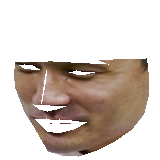

In [10]:
skin_1

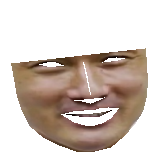

In [11]:
skin_2

In [6]:
skin_tone_similarity

NameError: name 'skin_tone_similarity' is not defined

In [7]:
IMAGE_PATH_1 = "../images/joe_biden/joe_biden_1.jpg"
IMAGE_PATH_2 = "../images/musician_farrah/00001.jpg"

results = get_skin_tone_similarity_face(IMAGE_PATH_1, IMAGE_PATH_2)
skin_tone_similarity, skin_1, skin_2, skin_tone_1, skin_tone_2 = results

../images/joe_biden/joe_biden_1.jpg


c:\users\tay.yq.xtraman\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


../images/musician_farrah/00001.jpg


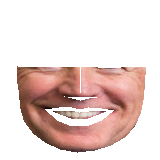

In [8]:
skin_1

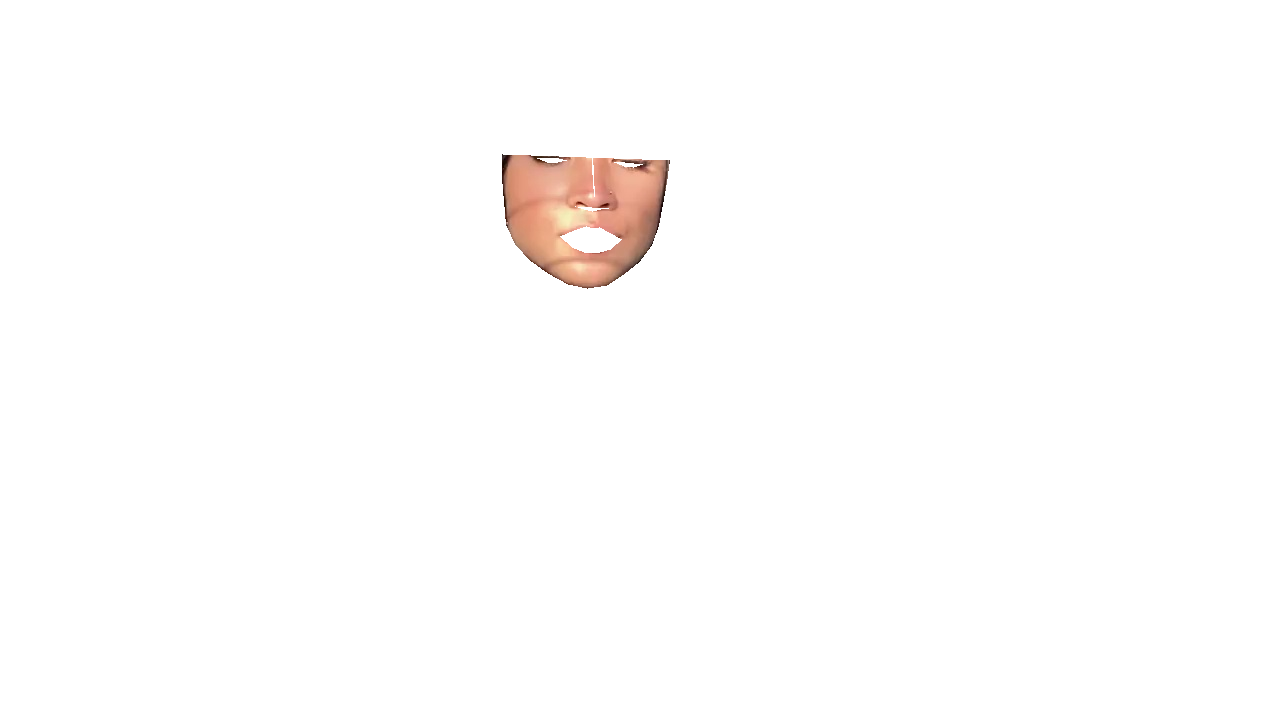

In [9]:
skin_2

In [10]:
skin_tone_similarity

0.9803921568627452

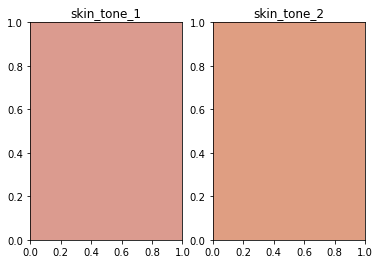

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots(nrows=1, ncols=2)

# Create a Rectangle patch
rect = patches.Rectangle((0, 0), 50, 30, fill=True, linewidth=1, color=rgb_to_hex(skin_tone_1[0]))

# Add the patch to the Axes
ax[0].add_patch(rect)
ax[0].set_title('skin_tone_1')

# Create a Rectangle patch
rect = patches.Rectangle((0, 0), 50, 30, fill=True, linewidth=1, color=rgb_to_hex(skin_tone_2[0]))

# Add the patch to the Axes
ax[1].add_patch(rect)
ax[1].set_title('skin_tone_2')

plt.show()

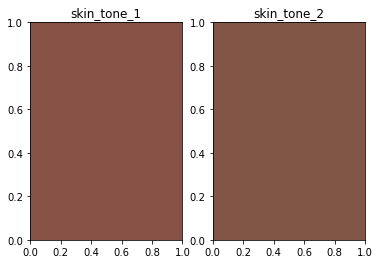

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots(nrows=1, ncols=2)

# Create a Rectangle patch
rect = patches.Rectangle((0, 0), 50, 30, fill=True, linewidth=1, color=rgb_to_hex(skin_tone_1[1]))

# Add the patch to the Axes
ax[0].add_patch(rect)
ax[0].set_title('skin_tone_1')

# Create a Rectangle patch
rect = patches.Rectangle((0, 0), 50, 30, fill=True, linewidth=1, color=rgb_to_hex(skin_tone_2[1]))

# Add the patch to the Axes
ax[1].add_patch(rect)
ax[1].set_title('skin_tone_2')

plt.show()